# Braitenberg environment notebook

Use this notebook to showcase how to create an environment in vivarium ... w a realistic physics ... 

## Imports

In [1]:
import time
import logging as lg
from enum import Enum
from functools import partial
from typing import Tuple

import jax
import flax
import jax.numpy as jnp

from jax import vmap, jit
from jax import random, ops, lax

from flax import struct
from jax_md.rigid_body import RigidBody
from jax_md import space, rigid_body, partition, simulate, quantity

from vivarium.utils import normal, render, render_history
from vivarium.simulator.general_physics_engine import total_collision_energy, friction_force, dynamics_fn

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Create classes for the environment

We use flax dataclasses to store all the information about our environment state (positions of all entities ..., features of agents and objects ...)

In [20]:
class EntityType(Enum):
    AGENT = 0
    OBJECT = 1

# No need to define position, momentum, force, and mass (i.e already in jax_md.simulate.NVEState)
@struct.dataclass
class EntityState(simulate.NVEState):
    entity_type: jnp.array
    entity_idx: jnp.array
    diameter: jnp.array
    friction: jnp.array
    exists: jnp.array

    @property
    def velocity(self) -> jnp.array:
        return self.momentum / self.mass
    
@struct.dataclass
class AgentState:
    ent_idx: jnp.array
    prox: jnp.array
    motor: jnp.array
    proximity_map_dist: jnp.array
    proximity_map_theta: jnp.array
    behavior: jnp.array
    wheel_diameter: jnp.array
    speed_mul: jnp.array
    max_speed: jnp.array
    theta_mul: jnp.array
    proxs_dist_max: jnp.array
    proxs_cos_min: jnp.array
    color: jnp.array

@struct.dataclass
class ObjectState:
    ent_idx: jnp.array 
    color: jnp.array

# TODO : Add obs field like in JaxMARL -> compute agents actions w a vmap on obs
@struct.dataclass
class State:
    time: jnp.int32
    box_size: jnp.int32
    max_agents: jnp.int32
    max_objects: jnp.int32
    neighbor_radius: jnp.float32
    dt: jnp.float32  # Give a more explicit name
    collision_alpha: jnp.float32
    collision_eps: jnp.float32
    entities: EntityState
    agents: AgentState
    objects: ObjectState

## Define helper functions to compute the proximeters of agents

Bc we use braitenberg vehicles ... need to compute values of proximeters for them to detect their environment ... 

In [3]:

### 2 Define functions that will be used in the step fn of the env ###

def relative_position(displ, theta):
    """
    Compute the relative distance and angle from a source agent to a target agent
    :param displ: Displacement vector (jnp arrray with shape (2,) from source to target
    :param theta: Orientation of the source agent (in the reference frame of the map)
    :return: dist: distance from source to target.
    relative_theta: relative angle of the target in the reference frame of the source agent (front direction at angle 0)
    """
    dist = jnp.linalg.norm(displ)
    norm_displ = displ / dist
    theta_displ = jnp.arccos(norm_displ[0]) * jnp.sign(jnp.arcsin(norm_displ[1]))
    relative_theta = theta_displ - theta
    return dist, relative_theta

proximity_map = vmap(relative_position, (0, 0))

# TODO : SHould redo all these functions with the prox computation because very hard to understand without vmap etcc
def sensor_fn(dist, relative_theta, dist_max, cos_min, target_exists):
    """
    Compute the proximeter activations (left, right) induced by the presence of an entity
    :param dist: distance from the agent to the entity
    :param relative_theta: angle of the entity in the reference frame of the agent (front direction at angle 0)
    :param dist_max: Max distance of the proximiter (will return 0. above this distance)
    :param cos_min: Field of view as a cosinus (e.g. cos_min = 0 means a pi/4 FoV on each proximeter, so pi/2 in total)
    :return: left and right proximeter activation in a jnp array with shape (2,)
    """
    cos_dir = jnp.cos(relative_theta)
    prox = 1. - (dist / dist_max)
    in_view = jnp.logical_and(dist < dist_max, cos_dir > cos_min)
    at_left = jnp.logical_and(True, jnp.sin(relative_theta) >= 0)
    left = in_view * at_left * prox
    right = in_view * (1. - at_left) * prox
    return jnp.array([left, right]) * target_exists  # i.e. 0 if target does not exist

sensor_fn = vmap(sensor_fn, (0, 0, 0, 0, 0))

def sensor(dist, relative_theta, dist_max, cos_min, max_agents, senders, target_exists):
    raw_proxs = sensor_fn(dist, relative_theta, dist_max, cos_min, target_exists)
    # Computes the maximum within the proximeter activations of agents on all their neigbhors.
    proxs = ops.segment_max(
        raw_proxs,
        senders, 
        max_agents)
    
    return proxs

# TODO : I think we should refactor this part of the code with a function using vmap
def compute_prox(state, agents_neighs_idx, target_exists_mask, displacement):
    """
    Set agents' proximeter activations
    :param state: full simulation State
    :param agents_neighs_idx: Neighbor representation, where sources are only agents. Matrix of shape (2, n_pairs),
    where n_pairs is the number of neighbor entity pairs where sources (first row) are agent indexes.
    :param target_exists_mask: Specify which target entities exist. Vector with shape (n_entities,).
    target_exists_mask[i] is True (resp. False) if entity of index i in state.entities exists (resp. don't exist).
    :return:
    """
    body = state.entities.position
    mask = target_exists_mask[agents_neighs_idx[1, :]]   
    senders, receivers = agents_neighs_idx
    Ra = body.center[senders]
    Rb = body.center[receivers]
    dR = - space.map_bond(displacement)(Ra, Rb)  # Looks like it should be opposite, but don't understand why

    # Create distance and angle maps between entities
    dist, theta = proximity_map(dR, body.orientation[senders])
    proximity_map_dist = jnp.zeros((state.agents.ent_idx.shape[0], state.entities.entity_idx.shape[0]))
    proximity_map_dist = proximity_map_dist.at[senders, receivers].set(dist)
    proximity_map_theta = jnp.zeros((state.agents.ent_idx.shape[0], state.entities.entity_idx.shape[0]))
    proximity_map_theta = proximity_map_theta.at[senders, receivers].set(theta)

    # TODO : refactor this function because a lot of redundancies in the arguments (state.agents)
    prox = sensor(dist, theta, state.agents.proxs_dist_max[senders],
                    state.agents.proxs_cos_min[senders], len(state.agents.ent_idx), senders, mask)
    
    return prox, proximity_map_dist, proximity_map_theta

## Create helper functions to compute motor activations of agents

Now that we know how to compute proximters values, we want our agents to act accordingly to them ... see how to map sensors values to motor activations (e.g w behaviors of attraction / repulsion towards some objects, agents ...)

In [4]:
# TODO : Refactor the following part
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
linear_behavior_enum = Enum('matrices', ['FEAR', 'AGGRESSION', 'LOVE', 'SHY'])

linear_behavior_matrices = {
    linear_behavior_enum.FEAR: jnp.array([[1., 0., 0.], [0., 1., 0.]]),
    linear_behavior_enum.AGGRESSION: jnp.array([[0., 1., 0.], [1., 0., 0.]]),
    linear_behavior_enum.LOVE: jnp.array([[-1., 0., 1.], [0., -1., 1.]]),
    linear_behavior_enum.SHY: jnp.array([[0., -1., 1.], [-1., 0., 1.]]),
}

def linear_behavior(proxs, motors, matrix):
    return matrix.dot(jnp.hstack((proxs, 1.)))

def apply_motors(proxs, motors):
    return motors

def noop(proxs, motors):
    return jnp.array([0., 0.])

behavior_bank = [partial(linear_behavior, matrix=linear_behavior_matrices[beh])
                 for beh in linear_behavior_enum] \
                + [apply_motors, noop]

behavior_name_map = {beh.name: i for i, beh in enumerate(linear_behavior_enum)}
behavior_name_map['manual'] = len(behavior_bank) - 2
behavior_name_map['noop'] = len(behavior_bank) - 1

lg.info(behavior_name_map)

# TODO : seems useless and unused
reversed_behavior_name_map = {i: name for name, i in behavior_name_map.items()}

def switch_fn(fn_list):
        def switch(index, *operands):
            return lax.switch(index, fn_list, *operands)
        return switch

multi_switch = vmap(switch_fn(behavior_bank), (0, 0, 0))

def sensorimotor(prox, behaviors, motor):
    motor = multi_switch(behaviors, prox, motor)
    return motor
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

def lr_2_fwd_rot(left_spd, right_spd, base_length, wheel_diameter):
    fwd = (wheel_diameter / 4.) * (left_spd + right_spd)
    rot = 0.5 * (wheel_diameter / base_length) * (right_spd - left_spd)
    return fwd, rot

def fwd_rot_2_lr(fwd, rot, base_length, wheel_diameter):
    left = ((2.0 * fwd) - (rot * base_length)) / wheel_diameter
    right = ((2.0 * fwd) + (rot * base_length)) / wheel_diameter
    return left, right

def motor_command(wheel_activation, base_length, wheel_diameter):
    fwd, rot = lr_2_fwd_rot(wheel_activation[0], wheel_activation[1], base_length, wheel_diameter)
    return fwd, rot

motor_command = vmap(motor_command, (0, 0, 0))

## Define a force function for the environment

Bc we want a world with a realistic physics, we wanna define how forces are going to be applied to our entities (collision and friction) as well as the motor forces for the braitenberg vehicles ... 

In [5]:

def braintenberg_force_fn(displacement):
    coll_force_fn = quantity.force(partial(total_collision_energy, displacement=displacement))

    def collision_force(state, neighbor, exists_mask):
        return coll_force_fn(
            state.entities.position.center,
            neighbor=neighbor,
            exists_mask=exists_mask,
            diameter=state.entities.diameter,
            epsilon=state.collision_eps,
            alpha=state.collision_alpha
            )

    def motor_force(state, exists_mask):
        agent_idx = state.agents.ent_idx

        body = rigid_body.RigidBody(
            center=state.entities.position.center[agent_idx],
            orientation=state.entities.position.orientation[agent_idx]
            )
        
        n = normal(body.orientation)

        fwd, rot = motor_command(
            state.agents.motor,
            state.entities.diameter[agent_idx],
            state.agents.wheel_diameter
            )
        # `a_max` arg is deprecated in recent versions of jax, replaced by `max`
        fwd = jnp.clip(fwd, a_max=state.agents.max_speed)

        cur_vel = state.entities.momentum.center[agent_idx] / state.entities.mass.center[agent_idx]
        cur_fwd_vel = vmap(jnp.dot)(cur_vel, n)
        cur_rot_vel = state.entities.momentum.orientation[agent_idx] / state.entities.mass.orientation[agent_idx]
        
        fwd_delta = fwd - cur_fwd_vel
        rot_delta = rot - cur_rot_vel

        fwd_force = n * jnp.tile(fwd_delta, (SPACE_NDIMS, 1)).T * jnp.tile(state.agents.speed_mul, (SPACE_NDIMS, 1)).T
        rot_force = rot_delta * state.agents.theta_mul

        center=jnp.zeros_like(state.entities.position.center).at[agent_idx].set(fwd_force)
        orientation=jnp.zeros_like(state.entities.position.orientation).at[agent_idx].set(rot_force)

        # apply mask to make non existing agents stand still
        orientation = jnp.where(exists_mask, orientation, 0.)
        # Because position has SPACE_NDMS dims, need to stack the mask to give it the same shape as center
        exists_mask = jnp.stack([exists_mask] * SPACE_NDIMS, axis=1)
        center = jnp.where(exists_mask, center, 0.)

        return rigid_body.RigidBody(center=center,
                                    orientation=orientation)
    

    def force_fn(state, neighbor, exists_mask):
        mf = motor_force(state, exists_mask)
        cf = collision_force(state, neighbor, exists_mask)
        ff = friction_force(state, exists_mask)
        
        center = cf + ff + mf.center
        orientation = mf.orientation
        return rigid_body.RigidBody(center=center, orientation=orientation)

    return force_fn

## Define the environment class with all those 

Now we have all the necessary elements to create our environment. We will use the classes and functions defined above in our Braitenberg environment ... 

Env needs two principal methods (+ tge __init__ to define the charasteristics of the env ... ): 
- init_state: create an initial 
- step

+ functions to handle neighborhood ....

#### TODO : Add the functions to update the spaces ... (I think there were things like that before)
#### TODO : Should write a render function as well (maybe take inspiration from EvoJax / JaxMALR ...)

In [6]:

SPACE_NDIMS = 2

class BraitenbergEnv:
    def __init__(
            self,
            box_size=100,
            dt=0.1,
            max_agents=10,
            max_objects=2,
            neighbor_radius=100.,
            collision_alpha=0.5,
            collision_eps=0.1,
            n_dims=2,
            seed=0,
            diameter=5.0,
            friction=0.1,
            mass_center=1.0,
            mass_orientation=0.125,
            existing_agents=10,
            existing_objects=2,
            behavior=behavior_name_map['AGGRESSION'],
            wheel_diameter=2.0,
            speed_mul=1.0,
            max_speed=10.0,
            theta_mul=1.0,
            prox_dist_max=40.0,
            prox_cos_min=0.0,
            agents_color=jnp.array([0.0, 0.0, 1.0]),
            objects_color=jnp.array([1.0, 0.0, 0.0])
    ):
        
        # TODO : add docstrings
        # general parameters
        self.box_size = box_size
        self.dt = dt
        self.max_agents = max_agents
        self.max_objects = max_objects
        self.neighbor_radius = neighbor_radius
        self.collision_alpha = collision_alpha
        self.collision_eps = collision_eps
        self.n_dims = n_dims
        self.seed = seed
        # entities parameters
        self.diameter = diameter
        self.friction = friction
        self.mass_center = mass_center
        self.mass_orientation = mass_orientation
        self.existing_agents = existing_agents
        self.existing_objects = existing_objects
        # agents parameters
        self.behavior = behavior
        self.wheel_diameter = wheel_diameter
        self.speed_mul = speed_mul
        self.max_speed = max_speed
        self.theta_mul = theta_mul
        self.prox_dist_max = prox_dist_max
        self.prox_cos_min = prox_cos_min
        self.agents_color = agents_color
        # objects parameters
        self.objects_color = objects_color
        # TODO : other parameters are defined when init_state is called, maybe coud / should set them to None here ? 


    # TODO : Split the initialization of entities, agents and objects w different functions ...
    def init_state(self) -> State:
        key = random.PRNGKey(self.seed)
        key, key_agents_pos, key_objects_pos, key_orientations = random.split(key, 4)

        n_entities = self.max_agents + self.max_objects # we store the entities data in jax arrays of length max_agents + max_objects 
        # Assign random positions to each entity in the environment
        agents_positions = random.uniform(key_agents_pos, (self.max_agents, self.n_dims)) * self.box_size
        objects_positions = random.uniform(key_objects_pos, (self.max_objects, self.n_dims)) * self.box_size
        positions = jnp.concatenate((agents_positions, objects_positions))
        # Assign random orientations between 0 and 2*pi to each entity
        orientations = random.uniform(key_orientations, (n_entities,)) * 2 * jnp.pi
        # Assign types to the entities
        agents_entities = jnp.full(self.max_agents, EntityType.AGENT.value)
        object_entities = jnp.full(self.max_objects, EntityType.OBJECT.value)
        entity_types = jnp.concatenate((agents_entities, object_entities), dtype=int)
        # Define arrays with existing entities
        exists_agents = jnp.concatenate((jnp.ones((self.existing_agents)), jnp.zeros((self.max_agents - self.existing_agents))))
        exists_objects = jnp.concatenate((jnp.ones((self.existing_objects)), jnp.zeros((self.max_objects - self.existing_objects))))
        exists = jnp.concatenate((exists_agents, exists_objects), dtype=int)
        # Entities idx of objects
        start_idx, stop_idx = self.max_agents, self.max_agents + self.max_objects 
        objects_ent_idx = jnp.arange(start_idx, stop_idx, dtype=int)

        entity_state = EntityState(
            position=RigidBody(center=positions, orientation=orientations),
            momentum=None,
            force=RigidBody(center=jnp.zeros((n_entities, 2)), orientation=jnp.zeros(n_entities)),
            mass=RigidBody(center=jnp.full((n_entities, 1), self.mass_center), orientation=jnp.full((n_entities), self.mass_orientation)),
            entity_type=entity_types,
            entity_idx = jnp.array(list(range(self.max_agents)) + list(range(self.max_objects))),
            diameter=jnp.full((n_entities), self.diameter),
            friction=jnp.full((n_entities), self.friction),
            exists=exists
        )

        agents_state = AgentState(
            # idx in the entities (ent_idx) state to map agents information in the different data structures
            ent_idx=jnp.arange(self.max_agents, dtype=int), 
            prox=jnp.zeros((self.max_agents, 2)),
            motor=jnp.zeros((self.max_agents, 2)),
            behavior=jnp.full((self.max_agents), self.behavior),
            wheel_diameter=jnp.full((self.max_agents), self.wheel_diameter),
            speed_mul=jnp.full((self.max_agents), self.speed_mul),
            max_speed=jnp.full((self.max_agents), self.max_speed),
            theta_mul=jnp.full((self.max_agents), self.theta_mul),
            proxs_dist_max=jnp.full((self.max_agents), self.prox_dist_max),
            proxs_cos_min=jnp.full((self.max_agents), self.prox_cos_min),
            proximity_map_dist=jnp.zeros((self.max_agents, 1)),
            proximity_map_theta=jnp.zeros((self.max_agents, 1)),
            color=jnp.tile(self.agents_color, (self.max_agents, 1))
        )

        objects_state = ObjectState(
            ent_idx=objects_ent_idx,
            color=jnp.tile(self.objects_color, (self.max_objects, 1))
        )

        lg.info('creating state')
        state = State(
            time=0,
            box_size=self.box_size,
            max_agents=self.max_agents,
            max_objects=self.max_objects,
            neighbor_radius=self.neighbor_radius,
            collision_alpha=self.collision_alpha,
            collision_eps=self.collision_eps,
            dt=self.dt,
            entities=entity_state,
            agents=agents_state,
            objects=objects_state
        )   

        # Create jax_md attributes for environment physics
        key, physics_key = random.split(key)
        self.displacement, self.shift = space.periodic(self.box_size)
        init_fn, apply_physics = dynamics_fn(self.displacement, self.shift, braintenberg_force_fn)
        self.init_fn = init_fn
        self.apply_physics = jit(apply_physics)
        self.neighbor_fn = partition.neighbor_list(
            self.displacement, 
            self.box_size,
            r_cutoff=self.neighbor_radius,
            dr_threshold=10.,
            capacity_multiplier=1.5,
            format=partition.Sparse
        )

        state = self.init_fn(state, physics_key)
        positions = state.entities.position.center
        lg.info('allocating neighbors')
        neighbors, agents_neighs_idx = self.allocate_neighbors(state)
        self.neighbors = neighbors
        self.agents_neighs_idx = agents_neighs_idx

        return state
    

    @partial(jit, static_argnums=(0,))
    def _step(self, state: State, neighbors: jnp.array, agents_neighs_idx: jnp.array) -> Tuple[State, jnp.array]:
        # 1 : Compute agents proximeter and motor activations
        exists_mask = jnp.where(state.entities.exists == 1, 1, 0)
        # TODO Not rly clean, should maybe only return proximeters, or split the functions 
        prox, proximity_dist_map, proximity_dist_theta = compute_prox(state, agents_neighs_idx, target_exists_mask=exists_mask, displacement=self.displacement)
        motor = sensorimotor(prox, state.agents.behavior, state.agents.motor)

        agents = state.agents.replace(
            prox=prox, 
            proximity_map_dist=proximity_dist_map, 
            proximity_map_theta=proximity_dist_theta,
            motor=motor
        )

        state = state.replace(agents=agents)
        # 2 : Move the entities by applying physics of the env (collision, friction and motor forces)
        entities = self.apply_physics(state, neighbors)

        # 3 : Apply specific consequences in the env (e.g eating an object)
        state = state.replace(
            time=state.time+1,
            entities=entities,
        )

        neighbors = neighbors.update(state.entities.position.center)

        return state, neighbors
    

    def step(self, state: State) -> State:
        current_state = state
        state, neighbors = self._step(current_state, self.neighbors, self.agents_neighs_idx)

        if self.neighbors.did_buffer_overflow:
            print("overflow")
            # reallocate neighbors and run the simulation from current_state
            lg.warning('BUFFER OVERFLOW: rebuilding neighbors')
            neighbors, agents_neighs_idx = self.allocate_neighbors(state)
            self.agents_neighs_idx = agents_neighs_idx
            assert not neighbors.did_buffer_overflow

        self.neighbors = neighbors
        return state

    def allocate_neighbors(self, state, position=None):
        position = state.entities.position.center if position is None else position
        neighbors = self.neighbor_fn.allocate(position)
        mask = state.entities.entity_type[neighbors.idx[0]] == EntityType.AGENT.value
        agents_neighs_idx = neighbors.idx[:, mask]
        return neighbors, agents_neighs_idx

## Initiate a state from the environment and render it

In [15]:
env = BraitenbergEnv()  
state = env.init_state()  

dict_state = flax.serialization.to_state_dict(state)
dict_state    

{'time': 0,
 'box_size': 100,
 'max_agents': 10,
 'max_objects': 2,
 'neighbor_radius': 100.0,
 'dt': 0.1,
 'collision_alpha': 0.5,
 'collision_eps': 0.1,
 'entities': {'position': RigidBody(center=Array([[ 3.7252188,  9.242689 ],
         [ 4.939151 , 86.78386  ],
         [93.74271  , 71.651375 ],
         [89.61038  , 64.47968  ],
         [51.115047 , 85.136246 ],
         [34.26517  , 60.67195  ],
         [58.65188  , 57.67032  ],
         [92.67553  ,  1.0239005],
         [94.60478  , 54.836296 ],
         [57.998978 , 75.63805  ],
         [31.563496 , 91.39798  ],
         [77.80601  , 22.647142 ]], dtype=float32), orientation=Array([5.8640995 , 3.5555892 , 3.3702946 , 2.5002196 , 6.139788  ,
         4.0296173 , 4.711335  , 3.085717  , 2.2339876 , 0.6937443 ,
         2.0312393 , 0.29639685], dtype=float32)),
  'momentum': RigidBody(center=Array([[ 0., -0.],
         [ 0., -0.],
         [ 0., -0.],
         [ 0.,  0.],
         [-0., -0.],
         [ 0., -0.],
         [ 0.

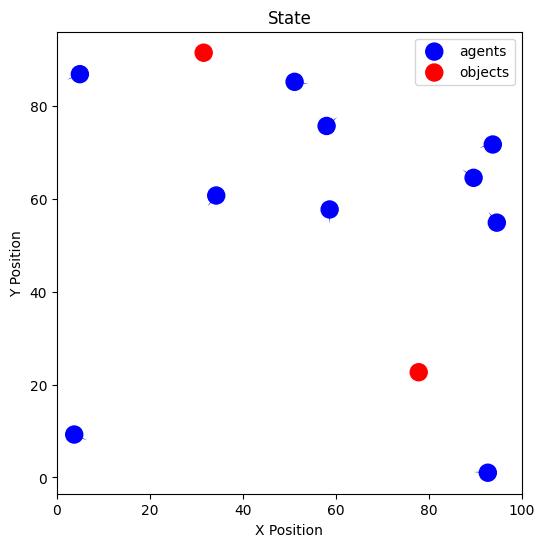

In [16]:
render(state)

## Run a simulation and visualize it 

In [18]:
n_steps = 5_000

hist = []

start = time.perf_counter()
for i in range(n_steps):
    state = env.step(state) 
    hist.append(state)
end = time.perf_counter()
print(f"Simulation ran in {end - start} for {n_steps} timesteps")

Simulation ran in 1.1898761210031807 for 10000 timesteps


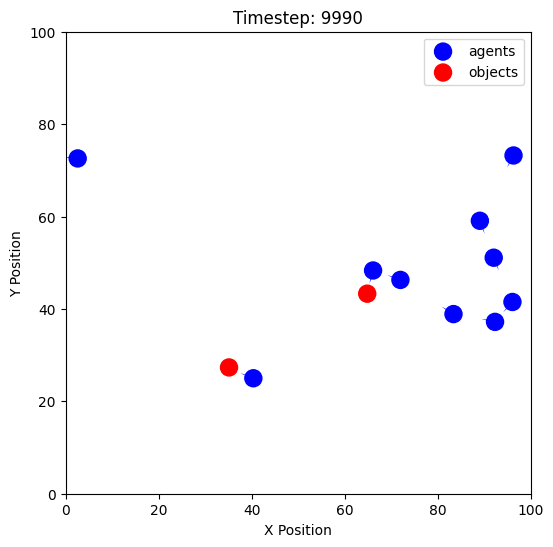

In [19]:
render_history(hist, skip_frames=10)

## Scale the size of the simulation

Increase the box_size, n_agents and objects ... 

#### TODO : Check the rendering functions bc here agents are way too big (but matplotlib scatter area mechanism kinda sucks)

In [29]:
env = BraitenbergEnv(box_size=500,
                     max_agents=100,
                     max_objects=20,
                     existing_agents=90,
                     existing_objects=20,
                     prox_dist_max=100) 
 
state = env.init_state()  

n_steps = 5_000

hist = []

start = time.perf_counter()
for i in range(n_steps):
    state = env.step(state) 
    hist.append(state)
end = time.perf_counter()
print(f"Simulation ran in {end - start} for {n_steps} timesteps")

overflow
Simulation ran in 3.715958105000027 for 5000 timesteps


In [31]:
env = BraitenbergEnv(box_size=500,
                     max_agents=100,
                     max_objects=20,
                     existing_agents=90,
                     existing_objects=20,
                     prox_dist_max=10) 

state = env.init_state()  

n_steps = 5_000

start = time.perf_counter()
for i in range(n_steps):
    state = env.step(state) 
end = time.perf_counter()
print(f"Simulation ran in {end - start} for {n_steps} timesteps")

Simulation ran in 2.861154723999789 for 5000 timesteps


Cool because neighbors rebuilding seems to work well but the recompilation time seems big (see other running time w agent with a low proximeter range (i.e they don't move and thus neighbor arrays are not computed again))

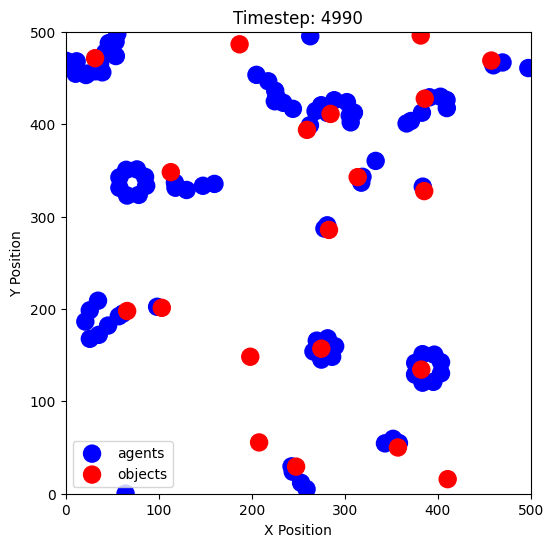

In [30]:
render_history(hist, skip_frames=10)